In [142]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error
from keras import optimizers
from math import sqrt

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns
import datetime



import warnings
import itertools
warnings.filterwarnings("ignore") # specify to ignore warning messages

from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error as mse

<h2>Load Data</h2>
Firstly let us get the data imported and take a look at a few observations

In [143]:
pd.set_option('display.float_format', '{:.2f}'.format)

In [144]:
df = pd.read_csv('data_comexstat.csv',  parse_dates=True, encoding="latin_1")

In [145]:
df.columns

Index(['date', 'product', 'state', 'country', 'type', 'route', 'tons', 'usd'], dtype='object')

In [146]:
df.head(5)

,date,product,state,country,type,route,tons,usd
0,1997-01-01,corn,ES,United States,Import,Sea,44.05,113029.00
1,1997-01-01,corn,GO,Argentina,Import,Ground,54.00,36720.00
2,1997-01-01,corn,GO,Bolivia,Export,Ground,0.20,180.00
3,1997-01-01,corn,GO,United States,Export,Sea,3.49,5688.00
4,1997-01-01,corn,MG,Argentina,Import,Ground,27.00,18630.00


In [147]:
df["product"].unique()

array(['corn', 'soybean_meal', 'soybean_oil', 'soybeans', 'sugar',
       'wheat'], dtype=object)

In [148]:
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month

<b>1</b><br>Show the evolution of total monthly and total annual exports from Brazil (all states and to everywhere) of ‘soybeans’, ‘soybean oil’ and ‘soybean meal’;

In [149]:
df.year.unique()

array([1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019])

In [150]:
df_expoxt = df[df['type'] == 'Export']

In [151]:
soybeans = df_expoxt[df_expoxt['product'] == 'soybeans']
soybean_oil = df_expoxt[df_expoxt['product'] == 'soybean_oil']
soybean_meal = df_expoxt[df_expoxt['product'] == 'soybean_meal']

In [152]:
soybeans_y = soybeans.groupby(['year'])['tons'].sum().reset_index()
soybean_oil_y = soybean_oil.groupby(['year'])['tons'].sum().reset_index()
soybean_meal_y = soybean_meal.groupby(['year'])['tons'].sum().reset_index()

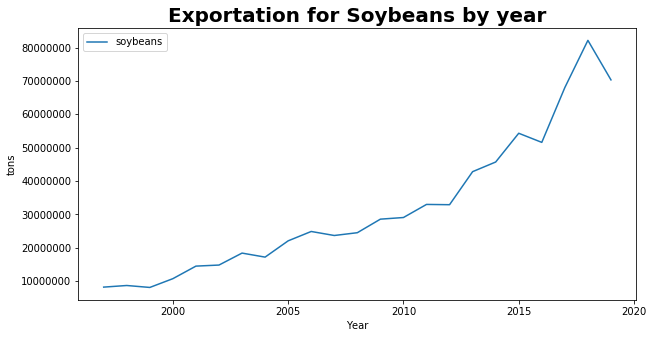

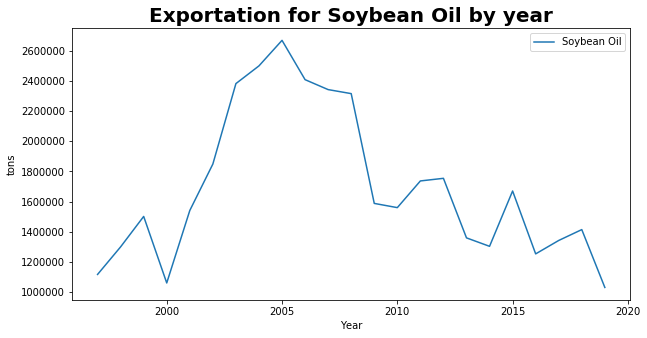

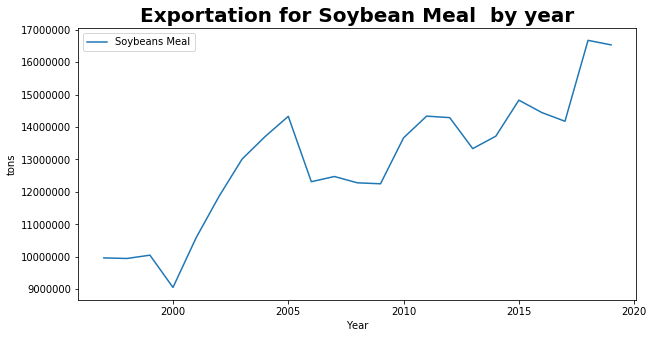

In [153]:
fig = plt.figure(figsize=(10.0, 5.0))
sns.lineplot(x = "year", y = "tons",  data=soybeans_y, palette = ['blue'])
plt.ticklabel_format(style = 'plain')
plt.ylabel("tons")
plt.xlabel("Year")
plt.legend(title = '', labels=['soybeans'])
plt.title('Exportation for Soybeans by year', size = 20, weight='semibold')
plt.show()

fig = plt.figure(figsize=(10.0, 5.0))
sns.lineplot(x = "year", y = "tons",  data=soybean_oil_y, palette = ['red'])
plt.ticklabel_format(style = 'plain')
plt.ylabel("tons")
plt.xlabel("Year")
plt.legend(title = '', labels=['Soybean Oil'])
plt.title('Exportation for Soybean Oil by year', size = 20, weight='semibold')
plt.show()

fig = plt.figure(figsize=(10.0, 5.0))
sns.lineplot(x = "year", y = "tons",  data=soybean_meal_y, palette = ['red'])
plt.ticklabel_format(style = 'plain')
plt.ylabel("tons")
plt.xlabel("Year")
plt.legend(title = '', labels=['Soybeans Meal'])
plt.title('Exportation for Soybean Meal  by year', size = 20, weight='semibold')
plt.show()

In [154]:
soybeans_m = soybeans.groupby(['month','year'])['tons'].sum().reset_index()
soybean_oil_m = soybean_oil.groupby(['month','year'])['tons'].sum().reset_index()
soybean_meal_m = soybean_meal.groupby(['month','year'])['tons'].sum().reset_index()

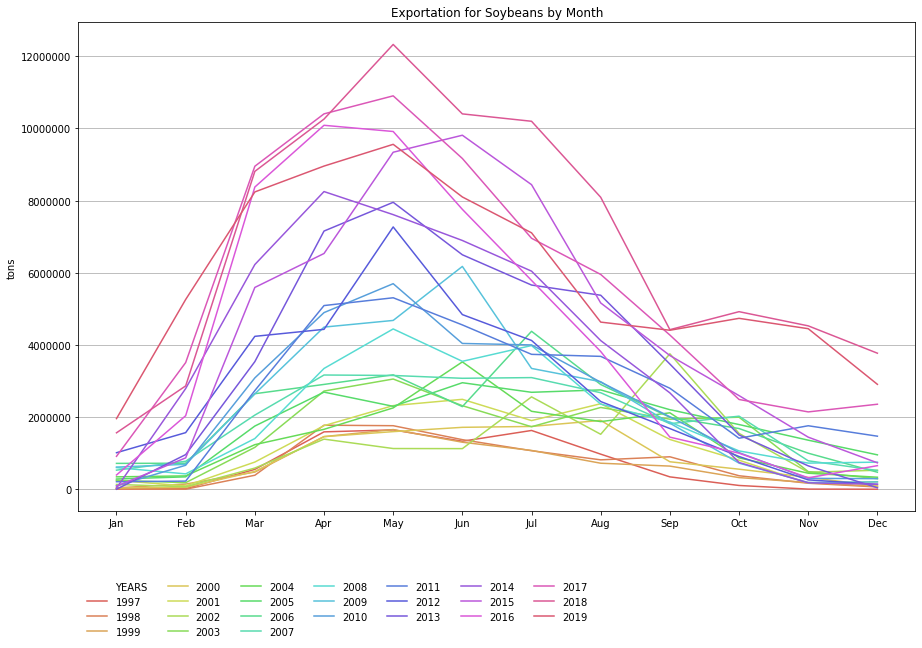

In [155]:
fig, ax = plt.subplots(figsize=(15, 9))

palette = sns.color_palette("hls", len(soybeans_m['year'].unique()))
sns.lineplot(soybeans_m['month'], soybeans_m['tons'], hue=soybeans_m['year'], ci=None, legend='full',palette=palette)

ax.set_title('Exportation for Soybeans by Month')
ax.set_ylabel('tons')
ax.set_xlabel('')
ax.ticklabel_format(style='plain')
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(soybeans_m['month'].unique(), labels = months )

legend = ax.legend(loc='center left', bbox_to_anchor=(0, -0.2),ncol=7, title=None)
legend.texts[0].set_text('YEARS')
legend.get_frame().set_linewidth(0.0)
plt.grid(axis='y')

plt.show()


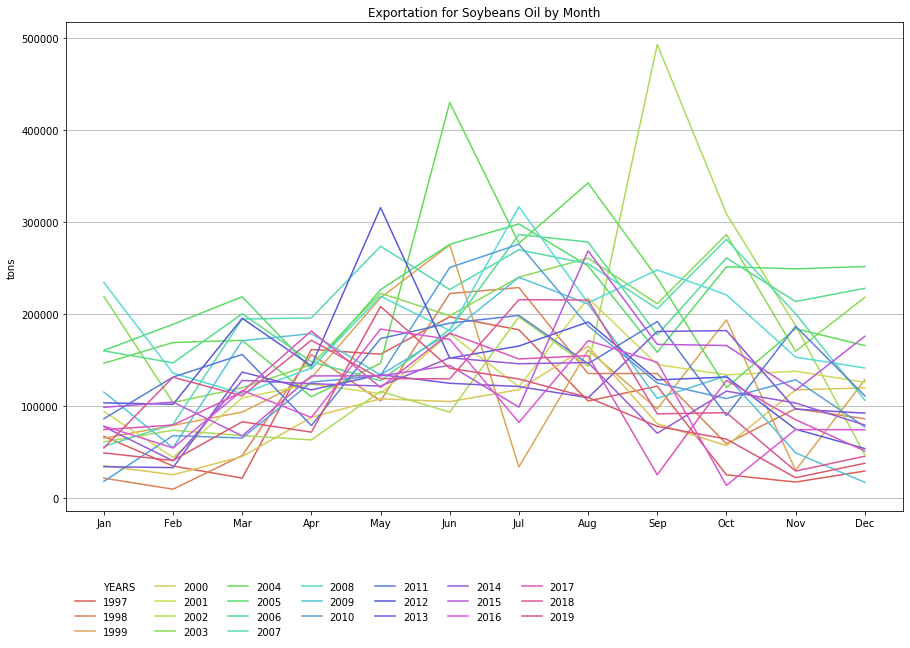

In [156]:
fig, ax = plt.subplots(figsize=(15, 9))

palette = sns.color_palette("hls", len(soybean_oil_m['year'].unique()))
sns.lineplot(soybean_oil_m['month'], soybean_oil_m['tons'], hue=soybean_oil_m['year'], ci=None, legend='full',palette=palette)

ax.set_title('Exportation for Soybeans Oil by Month')
ax.set_ylabel('tons')
ax.set_xlabel('')
ax.ticklabel_format(style='plain')
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(soybean_oil_m['month'].unique(), labels = months )

legend = ax.legend(loc='center left', bbox_to_anchor=(0, -0.2),ncol=7, title=None)
legend.texts[0].set_text('YEARS')
legend.get_frame().set_linewidth(0.0)
plt.grid(axis='y')

plt.show()


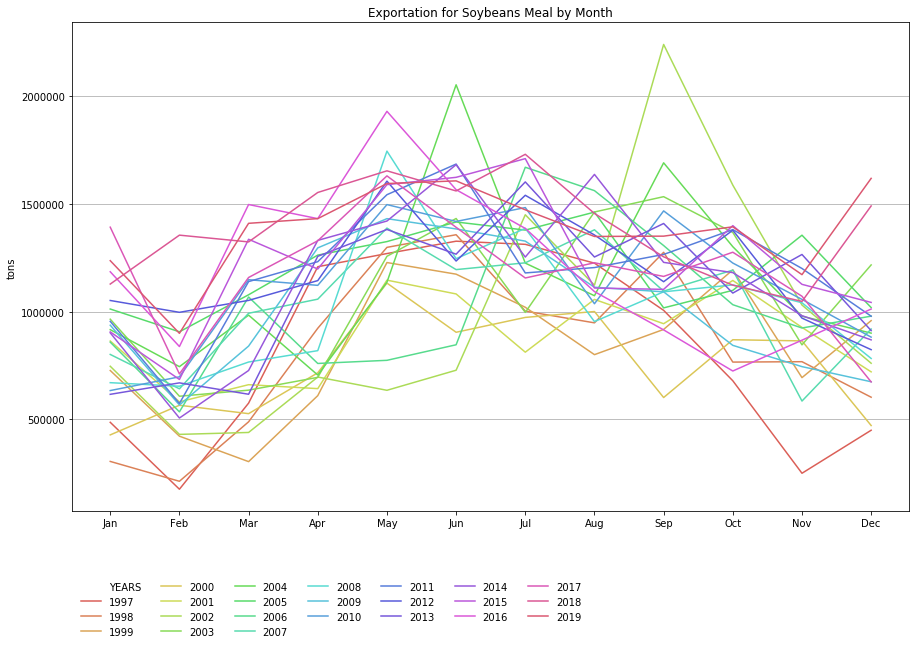

In [157]:
fig, ax = plt.subplots(figsize=(15, 9))

palette = sns.color_palette("hls", len(soybean_oil_m['year'].unique()))
sns.lineplot(soybean_meal_m['month'], soybean_meal_m['tons'], hue=soybean_meal_m['year'], ci=None, legend='full',palette=palette)

ax.set_title('Exportation for Soybeans Meal by Month')
ax.set_ylabel('tons')
ax.set_xlabel('')
ax.ticklabel_format(style='plain')
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(soybean_meal_m['month'].unique(), labels = months )

legend = ax.legend(loc='center left', bbox_to_anchor=(0, -0.2),ncol=7, title=None)
legend.texts[0].set_text('YEARS')
legend.get_frame().set_linewidth(0.0)
plt.grid(axis='y')

plt.show()


<b>2</b><br>What are the 3 most important products exported by Brazil in the last 5 years?

In [158]:
now = datetime.datetime.now()
last_5year = now.year - 5
df_expoxt_last_5  = df_expoxt[df_expoxt['year'] >= last_5year]
df_expoxt_last_5 

,date,product,state,country,type,route,tons,usd,year,month
75505,2015-01-01,corn,BA,Morocco,Export,Sea,7486.34,1370000.00,2015,1
75506,2015-01-01,corn,DF,Taiwan,Export,Sea,6.08,1168.00,2015,1
75507,2015-01-01,corn,ES,South Korea,Export,Sea,50.00,8135.00,2015,1
75508,2015-01-01,corn,GO,China,Export,Sea,41331.17,8143579.00,2015,1
75509,2015-01-01,corn,GO,Costa Rica,Export,Sea,40.00,13140.00,2015,1
...,...,...,...,...,...,...,...,...,...,...
117952,2019-12-01,wheat,PR,United States,Export,Sea,0.40,400.00,2019,12
117957,2019-12-01,wheat,RS,Vietnam,Export,Sea,36698.00,6963002.00,2019,12
117961,2019-12-01,wheat,SP,Ireland,Export,Sea,0.50,477.00,2019,12
117963,2019-12-01,wheat,SP,Liberia,Export,Other,0.03,50.00,2019,12


In [159]:
df_expoxt_order = df_expoxt_last_5.groupby(['product'])['usd'].sum().reset_index()
df_expoxt_order = df_expoxt_order.sort_values("usd", ascending=False)
df_expoxt_order.head(3)

,product,usd
3,soybeans,123325529857.00
4,sugar,40938486021.00
1,soybean_meal,28407723437.00


<B>3</b><br>What are the main routes through which Brazil have been exporting ‘corn’ in the last few years? Are there differences in the relative importancem of routes depending on the product?


In [160]:
ex_route_gb = df_expoxt.groupby('product')['route'].value_counts() 

In [161]:
ex_route_gb

product       route 
corn          Sea       13448
              Ground     1830
              Air         917
              Other       731
              River       468
soybean_meal  Sea       17238
              Ground      291
              Air          58
              River        48
              Other        37
soybean_oil   Sea       10175
              Ground     2595
              Other      2377
              River        84
              Air          56
soybeans      Sea       19828
              River      1007
              Ground      538
              Air         260
              Other       184
sugar         Sea       27697
              Other      2924
              Ground     2072
              Air         162
              River       133
wheat         Sea         448
              Ground      124
              Other       102
              Air          29
Name: route, dtype: int64

<b>4</b><br>Which countries have been the most important trade partners for Brazil in terms of ‘corn’ and ‘sugar’ in the last 3 years?

In [162]:
last_3year = now.year - 3

<b>Corn</b>

In [163]:
ex_corn = df[(df['year'] >= last_3year) & (df['type'] =='Export' ) & ((df['product'] == 'corn') )]

In [164]:
ex_corn_gb = ex_corn.groupby('country')['usd'].sum().reset_index()
ex_corn_gb_order = ex_corn_gb.sort_values("usd", ascending=False)
ex_corn_gb_order.head(5)

,country,usd
45,Iran,2822336281.00
52,Japan,1574975592.00
109,Vietnam,1551035208.00
30,Egypt,1375065136.00
92,Spain,1335769607.00


<b>Sugar</b>

In [165]:
ex_sugar = df[(df['year'] >= last_3year) & (df['type'] =='Export' ) & ((df['product'] == 'sugar') )]

In [166]:
ex_sugar_gb = ex_sugar.groupby('country')['usd'].sum().reset_index()
ex_sugar_gb_order = ex_sugar_gb.sort_values("usd", ascending=False)
ex_sugar_gb_order.head(5)

,country,usd
2,Algeria,2176380928.00
12,Bangladesh,2063174600.00
67,India,1696094938.00
146,United Arab Emirates,1538397895.00
119,Saudi Arabia,1380455693.00


<b>5</b><br> What should be the total brazilian soybeans, soybean_meal, and corn export forecasts, in tons, for the next 11 years (2020-2030)? We’re mostly interested in the annual forecast

<b>soybeans</B>


In [167]:
soybeans_a_m = soybeans.groupby(['year','month'])['tons'].sum().reset_index()

In [168]:
soybeans_a_m

,year,month,tons
0,1997,1,14030.00
1,1997,2,17095.00
2,1997,3,550157.55
3,1997,4,1589692.91
4,1997,5,1644029.75
...,...,...,...
271,2019,8,4631223.35
272,2019,9,4405770.14
273,2019,10,4735819.02
274,2019,11,4448635.32


In [169]:
covariates = pd.read_excel('covariates.xlsx')
covariates.head(3)

,year,price_soybeans,price_corn,price_soybean_meal,gdp_china,gdp_iran,gpd_netherlands,gdp_spain,gdp_thailand,gdp_world,gdp_egypt,gdp_japan,gdp_vietnam
0,1979,nan,nan,nan,100.00,100.00,nan,100.00,100.00,100.00,100.00,100.00,100.00
1,1980,100.00,100.00,100.00,107.90,81.20,100.00,101.20,104.60,102.10,103.40,103.20,96.50
2,1981,98.53,103.89,99.81,113.40,74.22,99.50,100.80,110.77,104.04,105.67,107.53,102.10


In [170]:
soybeans_a_m_cov = pd.merge(soybeans_a_m,
                 covariates[['year','price_soybeans', 'gdp_world']],
                 on='year')

In [171]:
soybeans_a_m_cov

,year,month,tons,price_soybeans,gdp_world
0,1997,1,14030.00,105.76,173.94
1,1997,2,17095.00,105.76,173.94
2,1997,3,550157.55,105.76,173.94
3,1997,4,1589692.91,105.76,173.94
4,1997,5,1644029.75,105.76,173.94
...,...,...,...,...,...
271,2019,8,4631223.35,123.25,391.07
272,2019,9,4405770.14,123.25,391.07
273,2019,10,4735819.02,123.25,391.07
274,2019,11,4448635.32,123.25,391.07


In [172]:
soybeans_a_m_cov.dropna(inplace=True)

In [173]:
soybeans_a_m_cov.shape

(276, 5)

In [174]:
soybeans_a_m_cov.isnull().values.any()

False

In [175]:
data_soybeans_a_m_cov = soybeans_a_m_cov[['year','tons','price_soybeans','gdp_world']].set_index('year')

In [176]:
data_soybeans_a_m_cov.tail(2)

,tons,price_soybeans,gdp_world
year,,,
2019,4448635.32,123.25,391.07
2019,2906495.29,123.25,391.07


In [177]:
dataset = data_soybeans_a_m_cov.values

In [178]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data_soybeans_a_m_cov)

In [179]:
training_data_len = int(np.ceil( len(scaled_data) * .9 ))

In [180]:
training_data_len

249

In [181]:
NMONTHS = 36

In [182]:
train_data = scaled_data[0:int(training_data_len), :]
test_data = scaled_data[training_data_len - NMONTHS: , :]

In [183]:
train_data.shape

(249, 3)

In [184]:
x_train = []
y_train = []

for i in range(NMONTHS, len(train_data)):
    x_train.append(train_data[i-NMONTHS:i, 0:3])
    y_train.append(train_data[i, 0:3])

In [185]:
x_train, y_train = np.array(x_train), np.array(y_train)

#Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 3))

In [186]:
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(NMONTHS, len(test_data)):
    x_test.append(test_data[i-NMONTHS:i, 0:3])

x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 3))

In [187]:
x_train.shape , x_test.shape  

((213, 36, 3), (27, 36, 3))

In [188]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint



model = Sequential()
model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 3)))
model.add(Dropout(0.1))


model.add(LSTM(units = 50))
model.add(Dropout(0.3))

model.add(Dense(units = 3, activation = 'linear'))

model.compile(optimizer = 'adam', loss = 'mean_squared_error',
                  metrics = ['mean_absolute_error'])

es = EarlyStopping(monitor = 'loss', min_delta = 1e-10, patience = 10, verbose = 1)
rlr = ReduceLROnPlateau(monitor = 'loss', factor = 0.2, patience = 5, verbose = 1)
mcp = ModelCheckpoint(filepath = 'pesos.h5', monitor = 'loss', 
                      save_best_only = True, verbose = 1)
model.fit(x_train, y_train, epochs = 50, batch_size = 3, callbacks = [es, rlr, mcp])

Epoch 1/50
213/213 [==============================] - 8s 39ms/step - loss: 0.0398 - mean_absolute_error: 0.1421

Epoch 00001: loss improved from inf to 0.03978, saving model to pesos.h5
Epoch 2/50
213/213 [==============================] - 5s 25ms/step - loss: 0.0242 - mean_absolute_error: 0.1115

Epoch 00002: loss improved from 0.03978 to 0.02421, saving model to pesos.h5
Epoch 3/50
213/213 [==============================] - 6s 28ms/step - loss: 0.0242 - mean_absolute_error: 0.1104

Epoch 00003: loss improved from 0.02421 to 0.02418, saving model to pesos.h5
Epoch 4/50
213/213 [==============================] - 6s 28ms/step - loss: 0.0208 - mean_absolute_error: 0.1018

Epoch 00004: loss improved from 0.02418 to 0.02076, saving model to pesos.h5
Epoch 5/50
213/213 [==============================] - 6s 26ms/step - loss: 0.0180 - mean_absolute_error: 0.0928

Epoch 00005: loss improved from 0.02076 to 0.01801, saving model to pesos.h5
Epoch 6/50
213/213 [==============================] - 

213/213 [==============================] - 11s 51ms/step - loss: 0.0048 - mean_absolute_error: 0.0481

Epoch 00047: loss did not improve from 0.00455
Epoch 48/50
213/213 [==============================] - 11s 51ms/step - loss: 0.0050 - mean_absolute_error: 0.0491

Epoch 00048: loss did not improve from 0.00455
Epoch 49/50
213/213 [==============================] - 10s 48ms/step - loss: 0.0050 - mean_absolute_error: 0.0493

Epoch 00049: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.

Epoch 00049: loss did not improve from 0.00455
Epoch 50/50
213/213 [==============================] - 11s 50ms/step - loss: 0.0052 - mean_absolute_error: 0.0496

Epoch 00050: loss did not improve from 0.00455


In [189]:
# Get the models predicted price values 
predictions = model.predict(x_test)
trainPredict = scaler.inverse_transform(predictions)

In [190]:
predict =  pd.DataFrame(trainPredict, columns=['tons_p','price_soybeans_p','gdp_world_p'])

In [191]:
predict

,tons_p,price_soybeans_p,gdp_world_p
0,1296802.75,136.13,357.01
1,304359.72,136.87,359.06
2,234007.28,135.68,362.97
3,1768843.75,131.72,367.71
4,5013157.50,126.48,371.63
5,8472533.00,126.12,374.06
6,10512838.00,129.18,376.34
7,10482880.00,131.32,376.75
8,9124706.00,131.19,375.89
9,7075646.00,130.07,373.54


In [192]:
valid = data_soybeans_a_m_cov[training_data_len:]
valid

,tons,price_soybeans,gdp_world
year,,,
2017,2486938.13,135.24,366.84
2017,2142729.38,135.24,366.84
2017,2355418.01,135.24,366.84
2018,1563569.04,129.10,380.05
2018,2863252.72,129.10,380.05
2018,8808907.72,129.10,380.05
2018,10257469.27,129.10,380.05
2018,12325914.22,129.10,380.05
2018,10401504.60,129.10,380.05


In [193]:
valid['price_soybeans_p']  = predict['price_soybeans_p']
valid['gdp_world_p']  = predict['gdp_world_p']
valid['tons_p']  = predict['tons_p']
valid[['tons_p', 'price_soybeans_p','gdp_world_p']] = predict[['tons_p', 'price_soybeans_p','gdp_world_p']].to_numpy()
valid

,tons,price_soybeans,gdp_world,price_soybeans_p,gdp_world_p,tons_p
year,,,,,,
2017,2486938.13,135.24,366.84,136.13,357.01,1296802.75
2017,2142729.38,135.24,366.84,136.87,359.06,304359.72
2017,2355418.01,135.24,366.84,135.68,362.97,234007.28
2018,1563569.04,129.10,380.05,131.72,367.71,1768843.75
2018,2863252.72,129.10,380.05,126.48,371.63,5013157.50
2018,8808907.72,129.10,380.05,126.12,374.06,8472533.00
2018,10257469.27,129.10,380.05,129.18,376.34,10512838.00
2018,12325914.22,129.10,380.05,131.32,376.75,10482880.00
2018,10401504.60,129.10,380.05,131.19,375.89,9124706.00


In [194]:
pred_tons = valid.groupby('year')[['tons','tons_p']].sum().drop_duplicates().reset_index()
pred_tons

,year,tons,tons_p
0,2017,6985085.52,1835169.75
1,2018,82147435.82,63001465.28
2,2019,70300144.69,65949620.38


In [195]:
pred_tons.reset_index(inplace=True)
pred_tons.set_index('year', drop=False, inplace=True)
pred_tons

,index,year,tons,tons_p
year,,,,
2017,0,2017,6985085.52,1835169.75
2018,1,2018,82147435.82,63001465.28
2019,2,2019,70300144.69,65949620.38


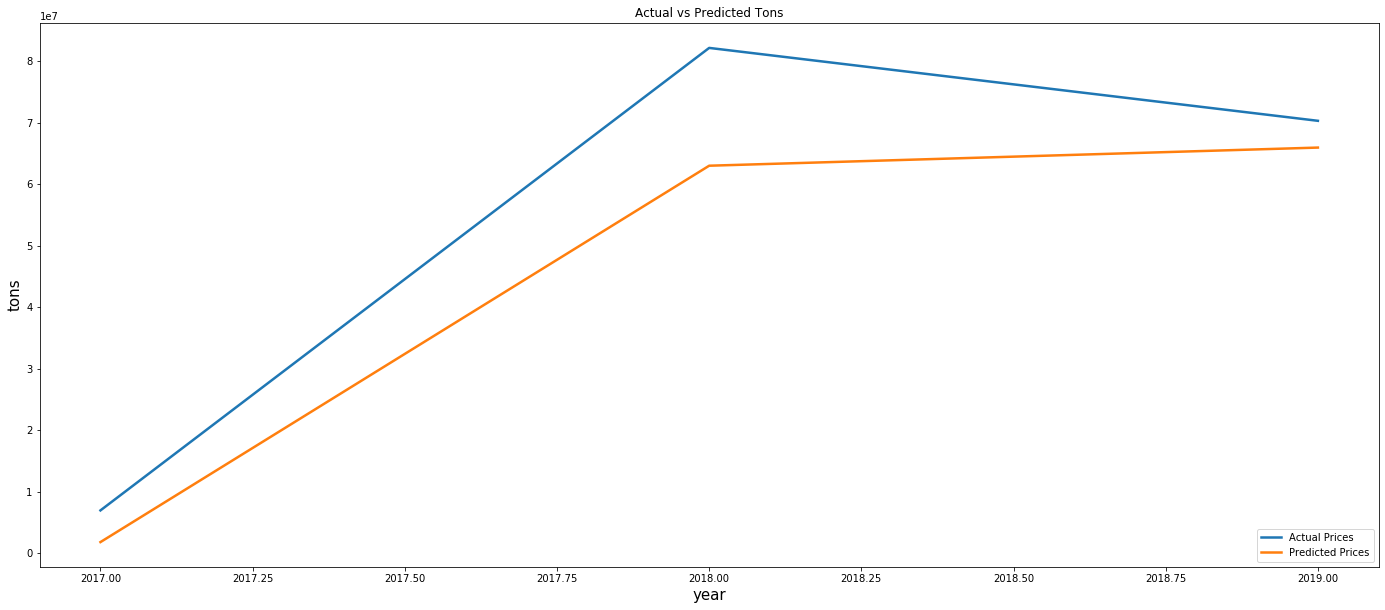

In [196]:
plt.figure(figsize=(24,10))
plt.title('Actual vs Predicted Tons')
plt.xlabel('year', fontsize=15)
plt.ylabel('tons', fontsize=15)
plt.plot(pred_tons[['tons', 'tons_p']],linewidth=2.5)
plt.legend(['Actual Prices', 'Predicted Prices'], loc='lower right')
plt.show()
 

In [222]:
for i in range(2020,2031):
    for j in range(1,13):
        x_test_forecast = []
        test_data_forecast = data_soybeans_a_m_cov.tail(NMONTHS)
        dataset_forecast = test_data_forecast.values
        scaled_data_forecast = scaler.fit_transform(dataset_forecast)
        x_test_forecast.append(scaled_data_2020)
        x_test_forecast = np.array(x_test_forecast)
        x_test_forecast = np.reshape(x_test_forecast, (x_test_forecast.shape[0], x_test_forecast.shape[1], 3))
        predictions_forecast = model.predict(x_test_forecast)
        pred_forecast= scaler.inverse_transform(predictions_forecast)
        new_row  = [pred_forecast[0][0],pred_forecast[0][1],pred_forecast[0][2]]
        data_soybeans_a_m_cov = data_soybeans_a_m_cov.append(pd.DataFrame([new_row],index=[i],columns=data_soybeans_a_m_cov.columns))

In [231]:
data_soybeans_a_m_cov

,tons,price_soybeans,gdp_world
year,,,
1997,14030.00,105.76,173.94
1997,17095.00,105.76,173.94
1997,550157.55,105.76,173.94
1997,1589692.91,105.76,173.94
1997,1644029.75,105.76,173.94
...,...,...,...
2030,3708324.75,123.56,410.32
2030,3708324.75,123.56,410.33
2030,3708324.75,123.56,410.33


In [228]:
data_soybeans_a_m_cov.index.name = 'year'

In [236]:
forecast = data_soybeans_a_m_cov.groupby('year')[['tons']].sum()

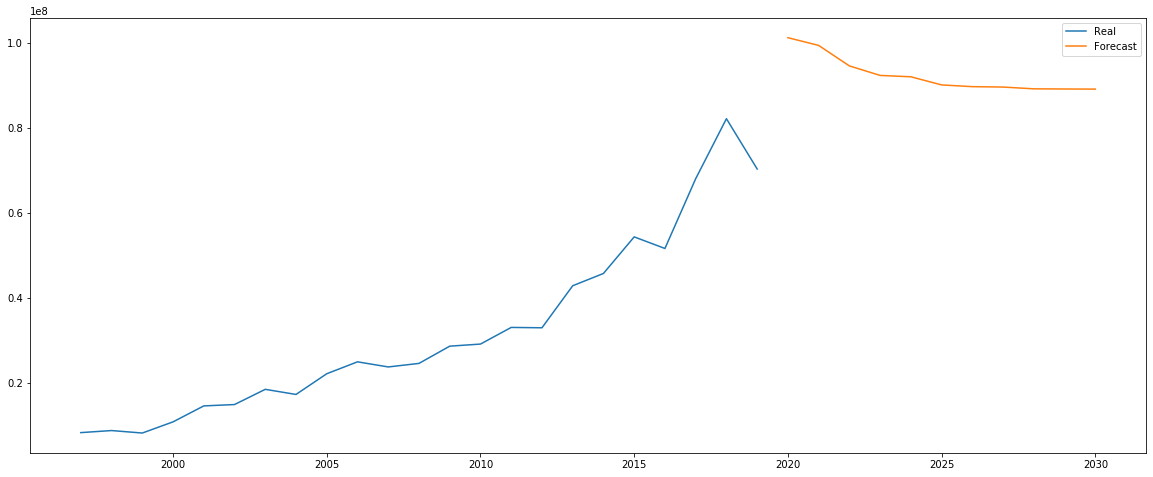

In [246]:
plt.figure(figsize=(20,8))
plt.plot(forecast[forecast.index < 2020], label = 'Real')
plt.plot(forecast[forecast.index > 2019], label = 'Forecast')
plt.legend();

<h2>The other models are the same</h2>